# Kalman Filtering w Diffrax
7/28/24

## Setup

$$\frac{dx}{dt} = Ax + Bu$$
$$y = Cx + Du + \epsilon$$

In [1]:
from types import SimpleNamespace
from typing import Optional

import diffrax as dfx
import equinox as eqx  # https://github.com/patrick-kidger/equinox
import jax.numpy as jnp
import jax.random as jr
import jax.tree_util as jtu
import matplotlib.pyplot as plt
import optax  # https://github.com/deepmind/optax

$$\vec{x} = (x, \dot{x})^T$$
$$\frac{d\vec{x}}{dt} = \begin{bmatrix}
0 & 1 \\
\omega^2 & -\gamma
\end{bmatrix}
\begin{bmatrix}
x \\
\dot{x}
\end{bmatrix} $$
$$y = \dot{x} +\epsilon(t)$$

In [16]:
class LTISystem(eqx.Module):
    A: jnp.ndarray
    B: jnp.ndarray
    C: jnp.ndarray
    D: jnp.ndarray
def SHO(omega=1,gamma=0) -> LTISystem:
    A = jnp.array([[0,1], [-omega**2, -gamma]])
    B = jnp.array([[0],[1]])
    C = jnp.array([0, 1])
    D = jnp.array([[0]])
    return LTISystem(A, B, C, D)

In [17]:
def interpolate_us(ts, us, B):
    if us is None:
        m = B.shape[-1]
        u_t = SimpleNamespace(evaluate=lambda t: jnp.zeros((m,)))
    else:
        u_t = dfx.LinearInterpolation(ts=ts, ys=us)
    return u_t
def diffeqsolve(
    rhs,
    ts: jnp.ndarray,
    y0: jnp.ndarray,
    solver: dfx.AbstractSolver = dfx.Dopri5(),
    stepsize_controller: dfx.AbstractStepSizeController = dfx.ConstantStepSize(),
    dt0: float = 0.01,
) -> jnp.ndarray:
    return dfx.diffeqsolve(
        dfx.ODETerm(rhs),
        solver=solver,
        stepsize_controller=stepsize_controller,
        t0=ts[0],
        t1=ts[-1],
        y0=y0,
        dt0=dt0,
        saveat=dfx.SaveAt(ts=ts),
    ).ys
def simulate_lti_system(
    sys: LTISystem,
    y0: jnp.ndarray,
    ts: jnp.ndarray,
    us: Optional[jnp.ndarray] = None,
    std_measurement_noise: float = 0.0,
    key=jr.PRNGKey(
        1,
    ),
):
    u_t = interpolate_us(ts, us, sys.B)
    def rhs(t, y, args):
        return sys.A @ y + sys.B @ u_t.evaluate(t)

    xs = diffeqsolve(rhs, ts, y0)
    # noisy measurements
    ys = xs @ sys.C.transpose()
    ys = ys + jr.normal(key, shape=ys.shape) * std_measurement_noise
    return xs, ys

/home/cjb/miniconda3/envs/jiang/lib/python3.12/site-packages/jax/_src/core.py:678: FutureWarning: unhashable type: <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>. Attempting to hash a tracer will lead to an error in a future JAX release.
  warnings.warn(
/home/cjb/miniconda3/envs/jiang/lib/python3.12/site-packages/jax/_src/core.py:678: FutureWarning: unhashable type: <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>. Attempting to hash a tracer will lead to an error in a future JAX release.
  warnings.warn(
/home/cjb/miniconda3/envs/jiang/lib/python3.12/site-packages/jax/_src/core.py:678: FutureWarning: unhashable type: <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>. Attempting to hash a tracer will lead to an error in a future JAX release.
  warnings.warn(


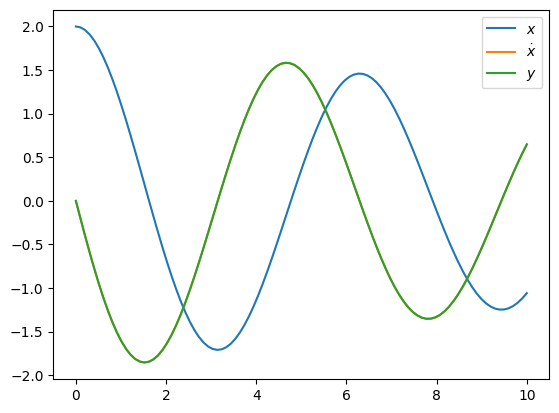

In [25]:
y0 = jnp.array([2,0])
ts = jnp.linspace(0,10,100)
xs, ys = simulate_lti_system(
  sys=SHO(omega=1,gamma=.1),
  y0=y0,
  ts=ts
)
plt.plot(ts,xs[:,0],label=r"$x$")
plt.plot(ts,xs[:,1],label=r"$\dot{x}$")
plt.plot(ts,ys,label=r"$y$")
plt.legend()
plt.show()

## Flavors of Least Squares

In [98]:
key = jr.key(1)
n = 2 # params to estimate
k = 20 # num measurements
sigma2 = .5
cov_diag = sigma2 * jnp.ones((k,1))
cov_diag = sigma2 * jnp.arange(1,k+1)
cov = jnp.diagflat(cov_diag).reshape((k,k))
means = jnp.zeros((k,))
print("Covariance:")
print("Means")
print(means)
eps = jr.multivariate_normal(key,means,cov).reshape((k,1))
print("Rand Normal")
print(eps)

Covariance:
Means
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Rand Normal
[[-0.69714904]
 [-1.0066605 ]
 [-0.2711229 ]
 [-1.9024571 ]
 [ 1.1743991 ]
 [-3.7076705 ]
 [-1.2339298 ]
 [-0.1321661 ]
 [-0.44729984]
 [-0.79040796]
 [-3.3130543 ]
 [-4.7602887 ]
 [ 4.155187  ]
 [ 0.63744664]
 [-4.8244386 ]
 [-2.0173001 ]
 [ 2.5082788 ]
 [-0.5759336 ]
 [ 1.6521857 ]
 [-1.6420699 ]]


### Weighted

In [101]:
H = jr.uniform(key,(k,n),minval=-5,maxval=5) # must be rank n, random is almost surely full rank
x = jnp.array([[-5],[-7]]) # to be estimated
y = H@x + eps
print("Y")
print(y)
i_cov = jnp.linalg.inv(cov)
x_hat = jnp.linalg.pinv(H.T @ i_cov @ H) @ H.T @ i_cov @ y 
print("Inverse Covariance")
print("Best Estimation for x")
print(x_hat)
print("Error")
print(jnp.abs(x_hat-x))


Y
[[-11.111132 ]
 [ -3.8261023]
 [ 12.778326 ]
 [-31.64141  ]
 [-10.685805 ]
 [  8.78656  ]
 [ 39.140224 ]
 [-23.834906 ]
 [ 28.161163 ]
 [-30.03177  ]
 [ 33.048347 ]
 [  4.125321 ]
 [ -9.194746 ]
 [-31.256886 ]
 [-31.63921  ]
 [  4.822534 ]
 [ 37.12939  ]
 [  6.2177677]
 [ -3.2627447]
 [ -4.2519426]]
Inverse Covariance
Best Estimation for x
[[-4.969807 ]
 [-6.9858823]]
Error
[[0.03019285]
 [0.01411772]]


### Recursive

In [202]:
import numpy as np
k = 15 # total number of samples to be taken
n = 1
x = jnp.array([[-1.33]]) # actual
x_hat_k = np.ones((k,n))
H_k = jnp.full((k,n),fill_value=jnp.array([[-1]]))
Sigma = 2*jnp.diagflat(jnp.arange(1,k+1))
v_k = lambda ki: jr.multivariate_normal(
  key=jr.key(2*ki),
  mean=jnp.zeros(k),
  cov=Sigma  
).reshape((k,1))
print("v_1")
print(v_k(1))
y_k = lambda ki: H_k @ x + v_k(ki)
print("Y_1")
print(y_k(1))
print("Y_2")
print(y_k(2))

v_1
[[ 0.7590385 ]
 [ 1.7878734 ]
 [-1.0890238 ]
 [-0.14538431]
 [ 2.549909  ]
 [-5.7465377 ]
 [ 6.2737412 ]
 [-3.721564  ]
 [-0.45166725]
 [ 9.806921  ]
 [-1.0862248 ]
 [ 5.2554035 ]
 [ 1.9883636 ]
 [ 0.33910275]
 [ 2.219297  ]]
Y_1
[[ 2.0890386 ]
 [ 3.1178734 ]
 [ 0.24097621]
 [ 1.1846157 ]
 [ 3.879909  ]
 [-4.416538  ]
 [ 7.603741  ]
 [-2.391564  ]
 [ 0.8783328 ]
 [11.136921  ]
 [ 0.24377525]
 [ 6.5854034 ]
 [ 3.3183637 ]
 [ 1.6691028 ]
 [ 3.5492969 ]]
Y_2
[[ 0.4570517 ]
 [-3.0337806 ]
 [-2.9711719 ]
 [-0.14186835]
 [-2.5217042 ]
 [ 1.9539618 ]
 [ 1.8103797 ]
 [ 2.7659514 ]
 [ 2.4192991 ]
 [ 3.6537275 ]
 [ 1.8399487 ]
 [ 1.0504364 ]
 [-4.7839966 ]
 [ 4.6808357 ]
 [-0.76289785]]


In [203]:
P_k = np.ones((k,n,n))
for ki in range(1,k):
  K_ki = P_k[ki-1] @ H_k.T @ jnp.linalg.inv(H_k @ P_k[ki-1] @ H_k.T + Sigma)
  y_ki = y_k(ki)
  old_xhat = x_hat_k[ki-1].reshape((n,1))
  print("xhat")
  print(old_xhat)
  x_hat_k[ki,:] = old_xhat + K_ki@(y_ki - H_k @ old_xhat)
  print("K_k")
  print(K_ki)
  new_pk = (jnp.eye(1) - K_ki@H_k)@P_k[ki-1]@(jnp.eye(1)-K_ki@H_k).T + K_ki@Sigma@K_ki.T
  P_k[ki] = new_pk

xhat
[[1.]]
K_k
[[-0.18803261 -0.09401628 -0.06267752 -0.04700813 -0.03760649 -0.03133876
  -0.02686179 -0.02350406 -0.0208925  -0.01880325 -0.01709386 -0.01566938
  -0.01446404 -0.01343089 -0.0125355 ]]
xhat
[[-0.98622704]]
K_k
[[-0.11578825 -0.05789413 -0.03859608 -0.02894707 -0.02315764 -0.01929804
  -0.01654117 -0.01447353 -0.01286536 -0.01157882 -0.0105262  -0.00964902
  -0.00890679 -0.00827059 -0.00771921]]
xhat
[[-0.50824618]]
K_k
[[-0.0836492  -0.04182461 -0.02788307 -0.0209123  -0.01672984 -0.01394153
  -0.01194989 -0.01045615 -0.00929435 -0.00836492 -0.00760447 -0.00697077
  -0.00643455 -0.00597494 -0.00557661]]
xhat
[[-0.66610694]]
K_k
[[-0.06547537 -0.03273768 -0.02182513 -0.01636884 -0.01309508 -0.01091256
  -0.00935362 -0.00818442 -0.00727504 -0.00654754 -0.00595231 -0.00545628
  -0.00503657 -0.00467681 -0.00436503]]
xhat
[[-1.04148436]]
K_k
[[-0.05378906 -0.02689452 -0.01792968 -0.01344726 -0.01075781 -0.00896484
  -0.00768415 -0.00672363 -0.00597656 -0.00537891 -0.00488

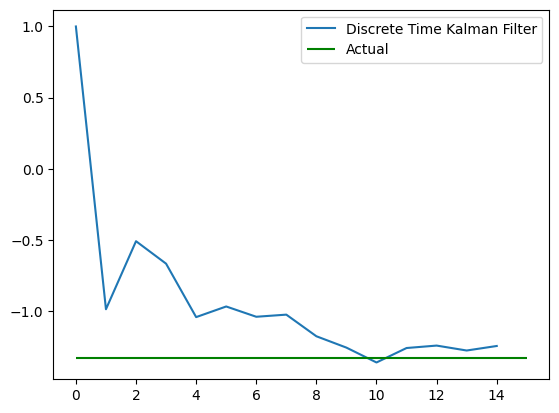

In [204]:
plt.plot(jnp.arange(0,k),x_hat_k,label="Discrete Time Kalman Filter")
plt.hlines(y=x,xmin=0,xmax=k,color="green",label="Actual")
plt.legend()
plt.show()